# Homework Assignment 9

**Question 1:** Use PySpark and the [Wine Reviews dataset](https://www.kaggle.com/zynicide/wine-reviews) to:
- Explore  the datasets using Spark DataFrame by creating **3 different data visualizations, including map visualization** (30pt)
- Create a regression model that can predict the Wine Review's points value and evaluate the model(20pt)

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

In [20]:
# !pip install geopandas
!pip install descartes

In [2]:
from google.colab import files
files.upload()
!ls

Saving winemag-data_first150k.csv to winemag-data_first150k.csv
sample_data		   spark-2.4.3-bin-hadoop2.7.tgz
spark-2.4.3-bin-hadoop2.7  winemag-data_first150k.csv


In [0]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SQLContext
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StringIndexer, Word2Vec
from pyspark.ml.classification import LogisticRegression
import pandas as pd
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.sql.functions import col, desc
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import IntegerType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import operator
from geopy.geocoders import Nominatim
import geopandas
from functools import lru_cache
from scipy.interpolate import interp1d 
import folium
from folium.plugins import HeatMap
%matplotlib inline


In [30]:
sc.stop()
sc = pyspark.SparkContext("local", appName="wine_DF")
sqlContext = SQLContext(sc)

dataset_path = "winemag-data_first150k.csv"
df = sqlContext.read.csv(dataset_path, inferSchema = True, header = True)
df = df.dropna(how='all')
df = df.dropDuplicates()
df.show()

+----+--------+--------------------+--------------------+------+-----+------------+--------------------+--------------------+--------------------+--------------------+
| _c0| country|         description|         designation|points|price|    province|            region_1|            region_2|             variety|              winery|
+----+--------+--------------------+--------------------+------+-----+------------+--------------------+--------------------+--------------------+--------------------+
|  39|   Italy|This bright, savo...|             Riserva|    90| 29.0|     Tuscany|    Chianti Classico|                null|           Red Blend|Castello di Monte...|
|  63|  France|L'Homme Mort is a...|L'Homme Mort Prem...|    91| 45.0|    Burgundy|             Chablis|                null|          Chardonnay| Domaine Chenevières|
| 178|      US|Juicy and soft in...|             Lot 525|    89| 29.0|  California|         Napa Valley|                Napa|  Cabernet Sauvignon|      Cameron 

In [31]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- country: string (nullable = true)
 |-- description: string (nullable = true)
 |-- designation: string (nullable = true)
 |-- points: string (nullable = true)
 |-- price: string (nullable = true)
 |-- province: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- region_2: string (nullable = true)
 |-- variety: string (nullable = true)
 |-- winery: string (nullable = true)



lets see how the points(which we want to predict) looks.

In [0]:
df.registerTempTable('reviews')
sql_res = sqlContext.sql('select points from reviews')

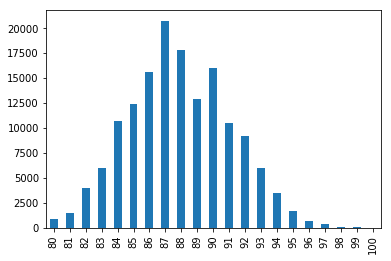

In [21]:
results_df = sql_res.toPandas()
sns.countplot(results_df['points'])

lets see the connection between wine-producing provinces of the world to the number of labels of wines they produce:

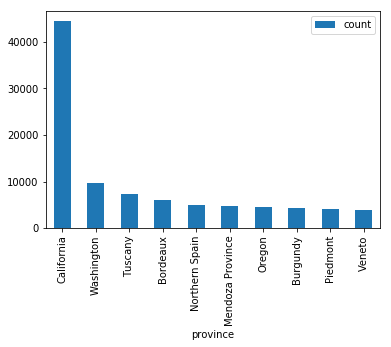

In [33]:
from pyspark.sql.functions import desc

result_df = df.groupby("province").count().orderBy(desc('count')).toPandas()
result_df.head(10).plot.bar(x='province',y='count')

California produces far more wine than any other province of the world!

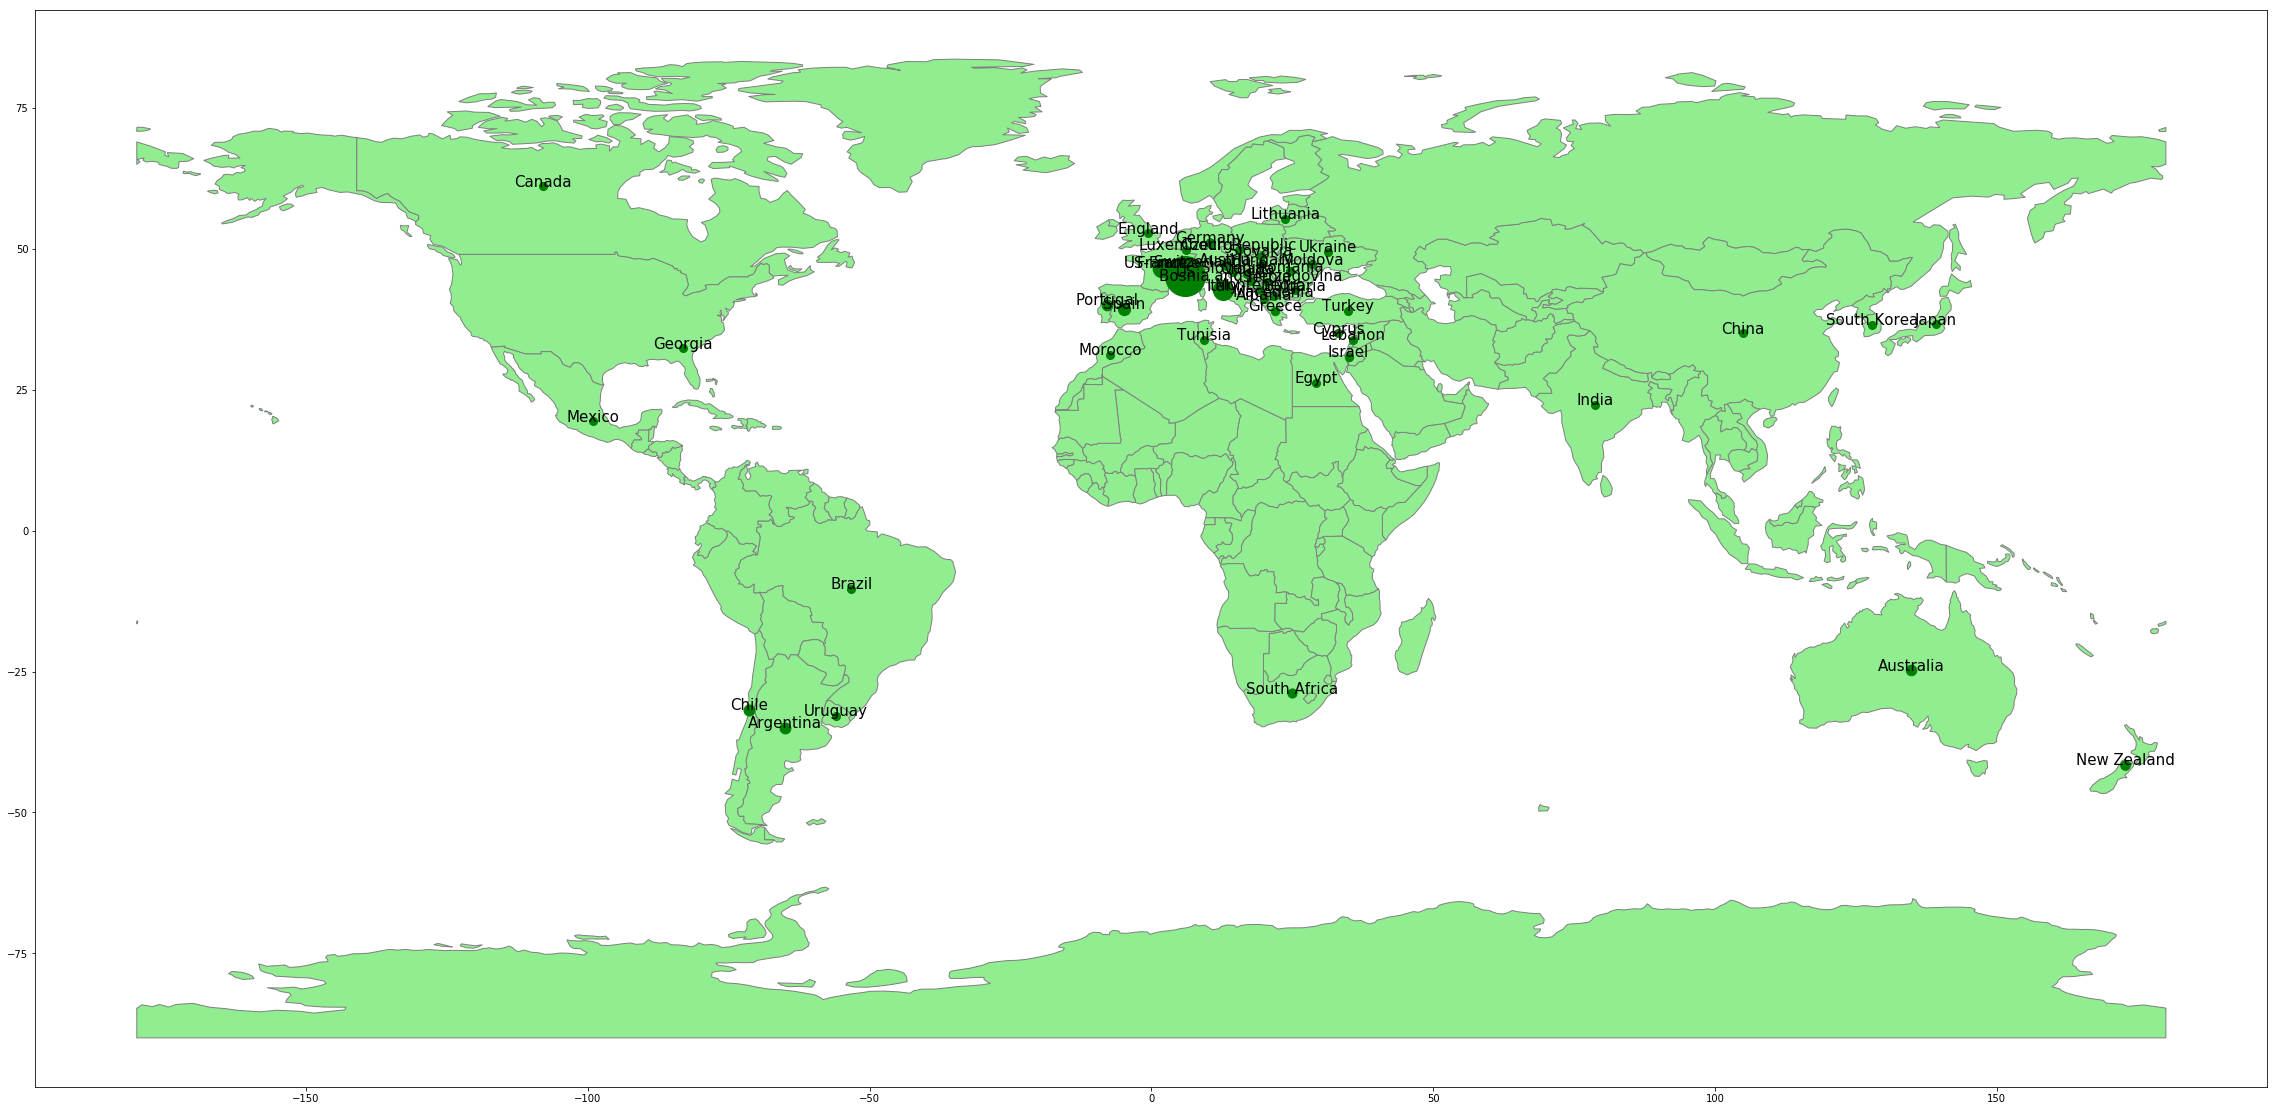

In [37]:
# wine gropued by country
countries_sorted_df = df.groupby("country").count().orderBy(desc('count')).toPandas()
locs = dict(zip(countries_sorted_df['country'], countries_sorted_df['count']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
geolocator = Nominatim(user_agent="Data Science Education App") #  Using OpenStreetMap Nominatim

m = interp1d([0,max(locs.values())],[8,40])

@lru_cache(maxsize=256)
def get_location(loc):
    return geolocator.geocode(loc)

fig, ax = plt.subplots(figsize=(40,40))
world.plot(ax=ax, color='lightgreen', edgecolor='gray')

for loc, v in locs.items():
    location = get_location(loc)
    if location is None:
        continue
        
    plt.plot(location.longitude,location.latitude, marker='o', color='green', markersize=m(v))
    plt.annotate(s=loc, xy=(location.longitude,location.latitude),
                 horizontalalignment='center', fontsize=15,color="black")

# regression model

In [53]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import StringIndexer

from pyspark.sql.types import IntegerType

indexer = StringIndexer(inputCol="country", outputCol="country_numeric",handleInvalid="skip").fit(df)
indexed_df = indexer.transform(df)
indexer = StringIndexer(inputCol="designation", outputCol="designation_numeric",handleInvalid="skip").fit(df)
indexed_df = indexer.transform(indexed_df)
indexer = StringIndexer(inputCol="province", outputCol="province_numeric",handleInvalid="skip").fit(df)
indexed_df = indexer.transform(indexed_df)
indexer = StringIndexer(inputCol="region_1", outputCol="region_1_numeric",handleInvalid="skip").fit(df)
indexed_df = indexer.transform(indexed_df)
indexer = StringIndexer(inputCol="region_2", outputCol="region_2_numeric",handleInvalid="skip").fit(df)
indexed_df = indexer.transform(indexed_df)
indexer = StringIndexer(inputCol="winery", outputCol="winery_numeric",handleInvalid="skip").fit(df)
indexed_df = indexer.transform(indexed_df)
indexer = StringIndexer(inputCol="variety", outputCol="variety_numeric",handleInvalid="skip").fit(df)
indexed_df = indexer.transform(indexed_df)
encoder = OneHotEncoderEstimator(inputCols=["country_numeric", "designation_numeric",'province_numeric', 'region_1_numeric', 'region_2_numeric', 'winery_numeric', 'variety_numeric'],
                                 outputCols=["country_vec", "designation_vec",'province_vec', 'region_1_vec', 'region_2_vec', 'winery_vec', 'variety_vec'])
model = encoder.fit(indexed_df)
encode_df = model.transform(indexed_df)


encode_df = encode_df.withColumn("price", encode_df["price"].cast(IntegerType()))
encode_df = encode_df.withColumn("points", encode_df["points"].cast(IntegerType()))
encode_df.show(3)

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/content/spark-2.4.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'DecisionTreeRegressor' object has no attribute '_java_obj'


+---+-------+--------------------+------------+------+-----+----------+--------------------+-----------------+------------------+--------------+---------------+-------------------+----------------+----------------+----------------+--------------+---------------+--------------+--------------------+-------------------+------------------+--------------+---------------+----------------+
|_c0|country|         description| designation|points|price|  province|            region_1|         region_2|           variety|        winery|country_numeric|designation_numeric|province_numeric|region_1_numeric|region_2_numeric|winery_numeric|variety_numeric|   country_vec|     designation_vec|         winery_vec|      region_1_vec|  region_2_vec|   province_vec|     variety_vec|
+---+-------+--------------------+------------+------+-----+----------+--------------------+-----------------+------------------+--------------+---------------+-------------------+----------------+----------------+--------------

In [0]:
encode_df= encode_df.dropna()

In [60]:
vectorAssembler = VectorAssembler(inputCols = ["country_vec", "designation_vec",'province_vec', 'region_1_vec', 'region_2_vec', 'winery_vec', 'variety_vec', 'price', ], outputCol = 'features')
wine_df = vectorAssembler.transform(encode_df)
wine_df = wine_df.select(['features', 'points'])
wine_df.show(3)

+--------------------+------+
|            features|points|
+--------------------+------+
|(47955,[0,21622,3...|    89|
|(47955,[0,717,306...|    89|
|(47955,[0,209,306...|    90|
+--------------------+------+
only showing top 3 rows



In [61]:
# Split the data into training and test sets (20% held out for testing)
(train_df, test_df) = wine_df.randomSplit([0.8, 0.2])

# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="features",labelCol='points')

dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="points", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 2.88679


In [64]:
dt_evaluator = RegressionEvaluator(
    labelCol="points", predictionCol="prediction", metricName="r2")
r2 = dt_evaluator.evaluate(dt_predictions)
print("R2 on test data = %g" % r2)

R2 on test data = 0.298937


In [62]:
dt_predictions.select("prediction","points").show()

+-----------------+------+
|       prediction|points|
+-----------------+------+
|86.03633267101901|    88|
|87.10610127035248|    84|
|89.62025827280064|    84|
|86.03633267101901|    86|
|87.10610127035248|    89|
|86.91164658634538|    86|
| 88.0578934565799|    86|
|87.10610127035248|    89|
|84.39607201309329|    85|
|90.80739161336176|    89|
|86.03633267101901|    84|
|90.80739161336176|    93|
| 88.0578934565799|    93|
|89.62025827280064|    88|
|89.62025827280064|    95|
|87.10610127035248|    89|
|88.66434494195688|    86|
|87.10610127035248|    87|
|90.80739161336176|    87|
|86.03633267101901|    84|
+-----------------+------+
only showing top 20 rows



In [0]:
sc.stop()

**Question 2:** Use PySpark and the [Used Car Listings dataset](https://www.kaggle.com/jpayne/852k-used-car-listings) to:
- Explore  the datasets using Spamrk DataFrame by creating **3 different data visualizations, including  map visualization** (30pt)
- Create a regression model that can predict a car's listing price and evaluate the model (20pt)



In [76]:

sc = pyspark.SparkContext("local", appName="car_DF")
sqlContext = SQLContext(sc)

dataset_path = "true_car_listings.csv"
df = sqlContext.read.csv(dataset_path, inferSchema = True, header = True)
df = df.dropna()
df = df.dropDuplicates()
df.show()

+-----+----+-------+---------------+-----+-----------------+-----+------------+
|Price|Year|Mileage|           City|State|              Vin| Make|       Model|
+-----+----+-------+---------------+-----+-----------------+-----+------------+
|16198|2013|  42122|     Prattville|   AL|19VDE1F78DE020807|Acura|  ILX5-Speed|
|13490|2012|  83032|        Ansonia|   CT|JH4CU2F67CC020708|Acura|TSXAutomatic|
|15990|2015|  64290|      Baltimore|   MD|19VDE1F7XFE007558|Acura|  ILX5-Speed|
|20500|2014|  27033|     Louisville|   KY|JH4CU2F67EC004009|Acura|  TSX5-Speed|
|20900|2015|  26651|Montgomeryville|   PA|19VDE1F72FE004122|Acura|  ILX5-Speed|
|22988|2016|  20608|   Jacksonville|   FL|19UDE2F70GA025764|Acura|ILXAutomatic|
|16998|2013|  24779|        Ardmore|   OK|19UUA8F22DA016272|Acura|      TLBase|
| 7995|2005|  71870|  Pompano Beach|   FL|19UUA66245A034195|Acura| TLAutomatic|
| 9990|2008|  87801|     Clearwater|   FL|19UUA66218A036362|Acura|       TL4dr|
|25500|2017|     71|        Norwalk|   C

In [77]:
df.printSchema()

root
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Mileage: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Vin: string (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)



In [78]:
print((df.count(), len(df.columns)))

(852092, 8)


In [0]:
df.registerTempTable('cars')

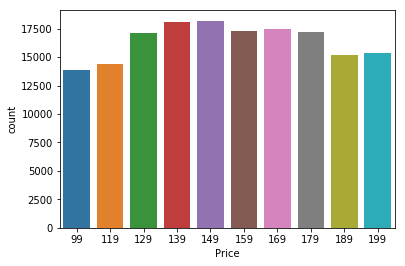

In [80]:
# top 10 most common prices range
sql_df = sqlContext.sql('select INT(Price/100) as Price, count(*) as count from cars group by INT(Price/100) order by count desc').toPandas().head(10)
ax = sns.barplot(x="Price", y="count", data=sql_df)

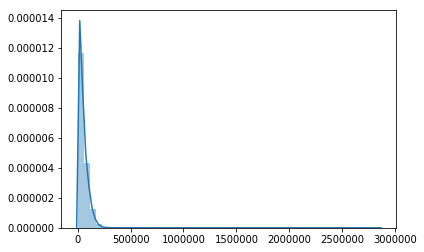

In [85]:
sns.distplot([row.Mileage for row in df.select('Mileage').collect()])

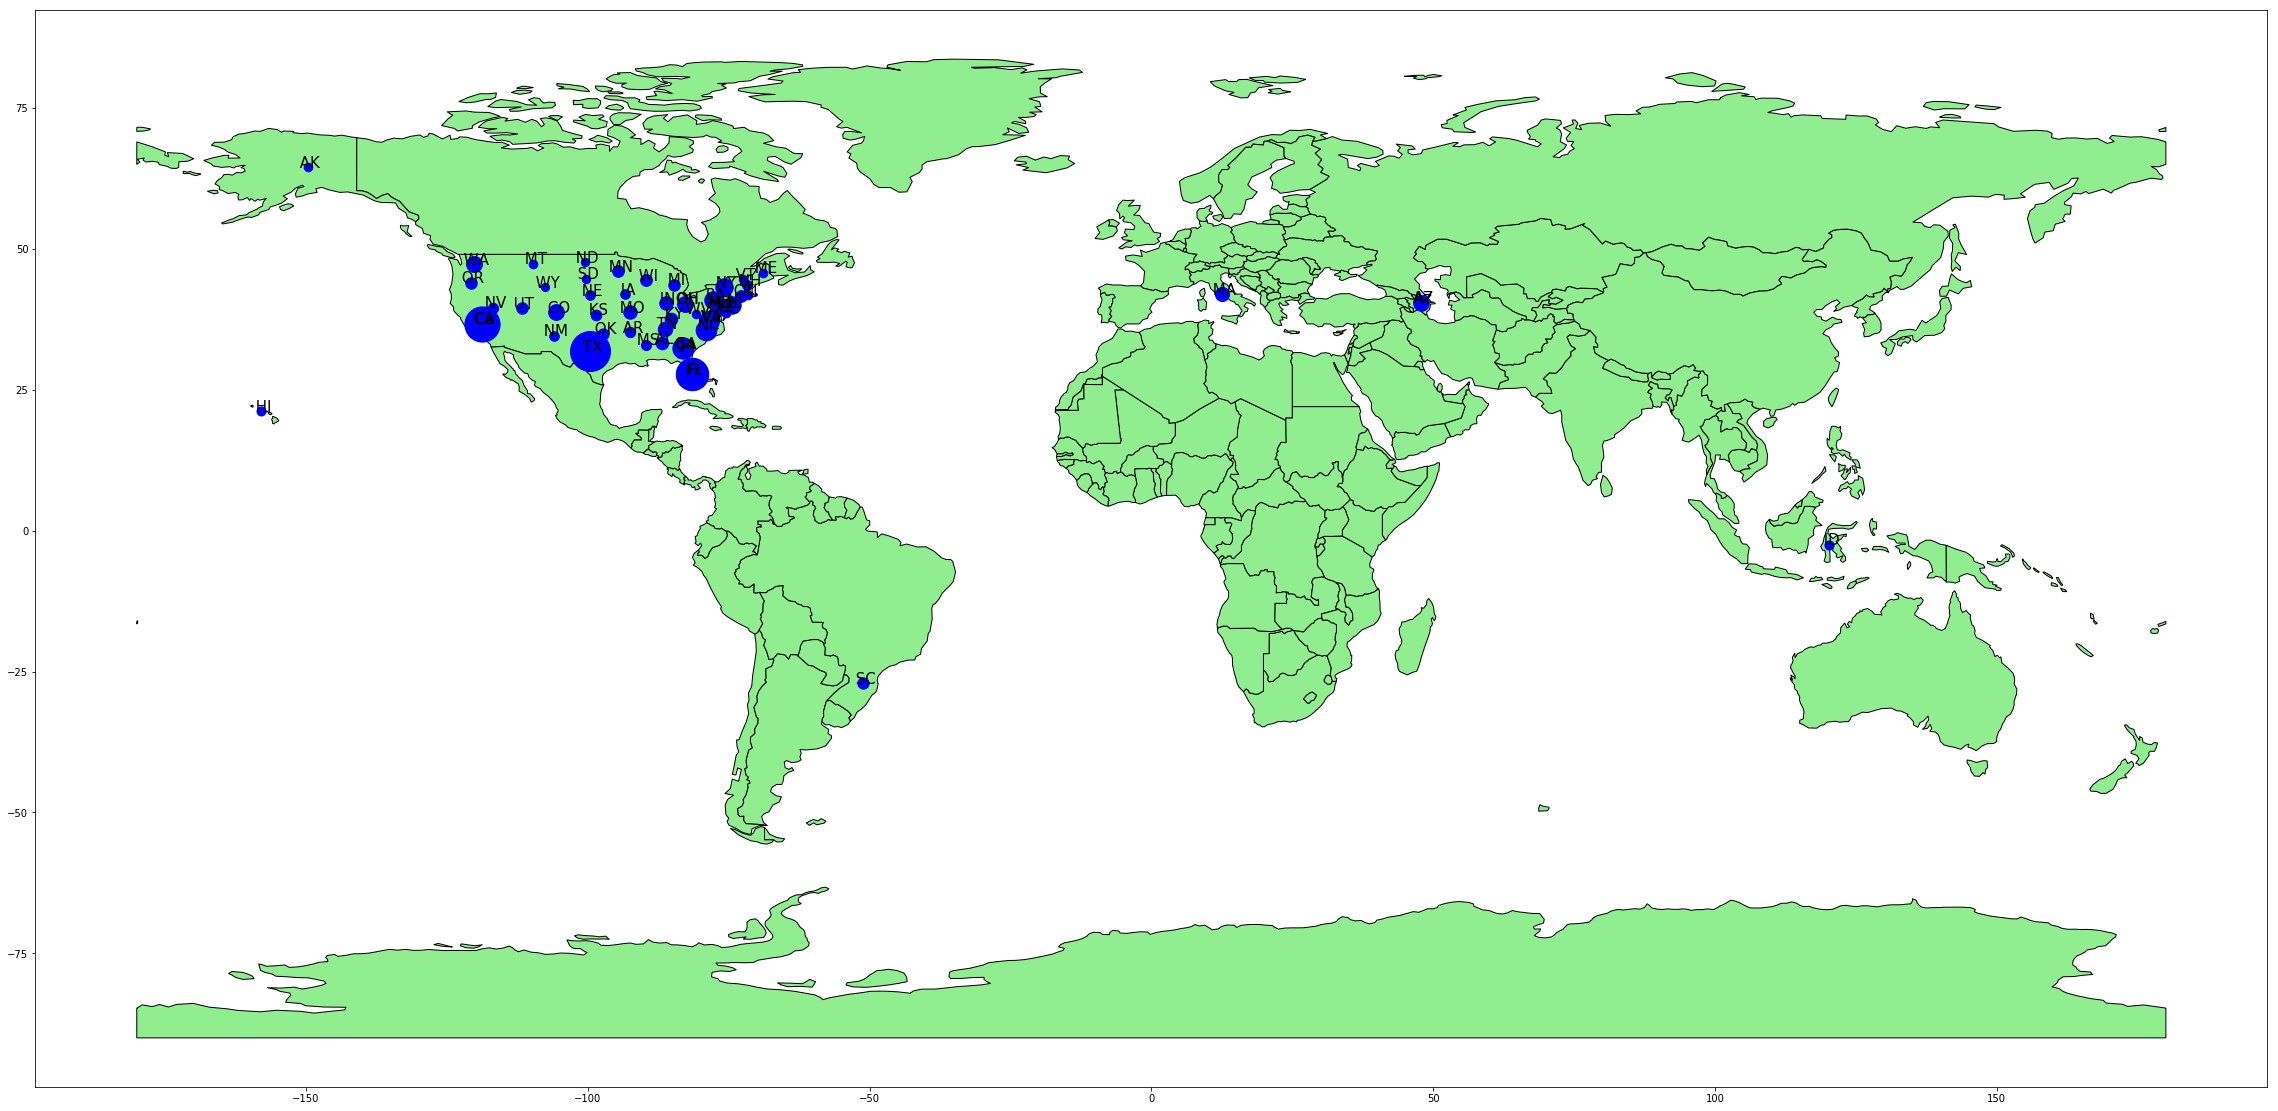

In [84]:
countries_df = df.groupby("State").count().orderBy(desc('count')).toPandas()
locs = dict(zip(countries_df['State'], countries_df['count']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
geolocator = Nominatim(user_agent="cars1") #  Using OpenStreetMap Nominatim

m = interp1d([4,max(locs.values())],[8,40])

@lru_cache(maxsize=256)
def get_location(loc):
    return geolocator.geocode(loc)

fig, ax = plt.subplots(figsize=(40,40))
world.plot(ax=ax, color='lightgreen', edgecolor='black')

for loc, v in locs.items():
    location = get_location(loc)
    if location is None:
        continue
        
    plt.plot(location.longitude,location.latitude, marker='o', color='blue', markersize=m(v))
    plt.annotate(s=loc, xy=(location.longitude,location.latitude),
                 horizontalalignment='center', fontsize=15,color="black")

In [86]:
indexer = StringIndexer(inputCol="City", outputCol="City_numeric",handleInvalid="skip").fit(df)
indexed_df = indexer.transform(df)
indexer = StringIndexer(inputCol="State", outputCol="State_numeric",handleInvalid="skip").fit(df)
indexed_df = indexer.transform(indexed_df)
indexer = StringIndexer(inputCol="Make", outputCol="Make_numeric",handleInvalid="skip").fit(df)
indexed_df = indexer.transform(indexed_df)
indexer = StringIndexer(inputCol="Model", outputCol="Model_numeric",handleInvalid="skip").fit(df)
indexed_df = indexer.transform(indexed_df)
encoder = OneHotEncoderEstimator(inputCols=["City_numeric", "State_numeric",'Make_numeric', 'Model_numeric'],
                                 outputCols=["City_vec", "State_vec",'Make_vec', 'Model_vec'])
model = encoder.fit(indexed_df)
encode_df = model.transform(indexed_df)
encode_df.show(3)

+-----+----+-------+----------+-----+-----------------+-----+------------+------------+-------------+------------+-------------+------------------+---------------+---------------+------------------+
|Price|Year|Mileage|      City|State|              Vin| Make|       Model|City_numeric|State_numeric|Make_numeric|Model_numeric|          City_vec|      State_vec|       Make_vec|         Model_vec|
+-----+----+-------+----------+-----+-----------------+-----+------------+------------+-------------+------------+-------------+------------------+---------------+---------------+------------------+
|16198|2013|  42122|Prattville|   AL|19VDE1F78DE020807|Acura|  ILX5-Speed|       728.0|         20.0|        22.0|        294.0|(2552,[728],[1.0])|(58,[20],[1.0])|(57,[22],[1.0])|(2735,[294],[1.0])|
|13490|2012|  83032|   Ansonia|   CT|JH4CU2F67CC020708|Acura|TSXAutomatic|       397.0|         23.0|        22.0|        617.0|(2552,[397],[1.0])|(58,[23],[1.0])|(57,[22],[1.0])|(2735,[617],[1.0])|
|1599

In [87]:
vectorAssembler = VectorAssembler(inputCols = ["Mileage","Year","City_vec", "State_vec",'Make_vec', 'Model_vec',], outputCol = 'features')
car_df = vectorAssembler.transform(encode_df)
car_df = car_df.select(['features', 'Price'])
car_df.show(3)

+--------------------+-----+
|            features|Price|
+--------------------+-----+
|(5404,[0,1,730,25...|16198|
|(5404,[0,1,399,25...|13490|
|(5404,[0,1,64,257...|15990|
+--------------------+-----+
only showing top 3 rows



In [88]:
# Split the data into training and test sets (20% held out for testing)
(train_df, test_df) = car_df.randomSplit([0.8, 0.2])

# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="features",labelCol='Price')

dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="Price", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 10835.8


In [90]:
train_df.describe().show()

+-------+------------------+
|summary|             Price|
+-------+------------------+
|  count|            681687|
|   mean| 21467.36512651701|
| stddev|13622.607726440214|
|    min|              1500|
|    max|            499500|
+-------+------------------+



In [92]:
dt_predictions.select("prediction","Price").show()

+------------------+-----+
|        prediction|Price|
+------------------+-----+
|  15643.9359118038|41981|
|22373.951187840346|24782|
|22373.951187840346|16733|
|22373.951187840346|37655|
|22373.951187840346|28700|
|22373.951187840346|16277|
|22373.951187840346|21297|
|22373.951187840346|48243|
|22373.951187840346|27943|
|22373.951187840346|11990|
|22373.951187840346|18491|
|22373.951187840346|28988|
|22373.951187840346|19999|
|22373.951187840346|39250|
|22373.951187840346|21425|
|22373.951187840346|36000|
|22373.951187840346|21499|
|22373.951187840346|18990|
|29656.318374635324|32988|
|  15643.9359118038|16984|
+------------------+-----+
only showing top 20 rows



In [0]:
sc.stop()